In [4]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, Input, Resizing, SpatialDropout2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
import json
import uuid
from tensorflow.keras import mixed_precision
from datetime import datetime
import matplotlib.pyplot as plt

In [5]:
# Set the policy to mixed_float16
mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6


In [6]:
# Configure GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and being used.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available. Using CPU.")

GPU is available and being used.


In [7]:
import os
import numpy as np
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_dir, data_type='train', batch_size=8, img_size=(256, 256), shuffle=True, augment=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.base_dir = base_dir
        self.data_type = data_type
        self.shuffle = shuffle
        self.augment = augment
        self.image_dir = os.path.join(base_dir, data_type, 'images')
        self.mask_dir = os.path.join(base_dir, data_type, 'masks')
        self.file_list = self.load_dataset()
        self.on_epoch_end()

    def load_dataset(self):
        image_files = os.listdir(self.image_dir)
        mask_files = os.listdir(self.mask_dir)
        image_files = sorted(image_files)
        mask_files = sorted(mask_files)
        assert len(image_files) == len(mask_files), "Number of images and masks do not match"
        for i in range(len(image_files)):
            if image_files[i].replace('.jpg', '') != mask_files[i].replace('_mask.png', ''):
                raise ValueError(f"Image and mask files do not match: {image_files[i]}, {mask_files[i]}")
        return image_files

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_file_list = [self.file_list[k] for k in indexes]
        images, masks = self.__data_generation(batch_file_list)
        return images, masks

    def _parse_function(self, filename):
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename.replace('.jpg', '_mask.png'))
    
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, self.img_size)
            image = tf.cast(image, tf.float32) / 255.0
    
            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.resize(mask, self.img_size)
            mask = tf.cast(mask, tf.float32) / 255.0
    
            if image.shape != (self.img_size[0], self.img_size[1], 3) or mask.shape != (self.img_size[0], self.img_size[1], 1):
                raise ValueError(f"Incorrect shape for image or mask. Image shape: {image.shape}, Mask shape: {mask.shape}")
    
            return image, mask
        except Exception as e:
            print(f"Error parsing file {filename}: {e}")
            return None, None

    def _augment_function(self, image, mask):
        aug_params = []
        
        # Horizontal flipping
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
            aug_params.append('Horizontal Flip')
    
        # Vertical flipping
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)
            aug_params.append('Vertical Flip')
    
        # Brightness adjustment
        image = tf.image.random_brightness(image, max_delta=0.1)
        aug_params.append('Brightness Adjustment')
    
        # Contrast adjustment
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        aug_params.append('Contrast Adjustment')
    
        # Saturation adjustment
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        aug_params.append('Saturation Adjustment')
    
        # Hue adjustment
        image = tf.image.random_hue(image, max_delta=0.1)
        aug_params.append('Hue Adjustment')
    
        # Ensure the image values are clipped to be within [0, 1]
        image = tf.clip_by_value(image, 0.0, 1.0)
    
        # Ensure the mask remains binary
        mask = tf.clip_by_value(mask, 0, 1)
        
        # Ensure masks are binary after every transformation (reapply binary constraint)
        mask = tf.cast(mask > 0.5, tf.float32)
    
        # Optional: Store the augmentation parameters if needed
        self.aug_params = aug_params  # Store in class variable if necessary
        
        # print(f"Applied augmentations: {aug_params}")  # Print augmentations for debugging
        
        return image, mask

    
    def __data_generation(self, batch_file_list):
        images = []
        masks = []

        for filename in batch_file_list:
            image, mask = self._parse_function(filename)
            if image is not None and mask is not None:
                if self.augment:
                    image, mask = self._augment_function(image, mask)
                images.append(image)
                masks.append(mask)

        return np.array(images), np.array(masks)
     
    def collect_all_masks(self):
        masks = []
        for filename in self.file_list:
            _, mask = self._parse_function(filename)
            if mask is not None:
                masks.append(mask)
        return np.array(masks)


In [8]:
# Cell 4: Set base directory and batch size
base_dir = 'E:\\study\\graduation\\vitiligo-assessment\\data'

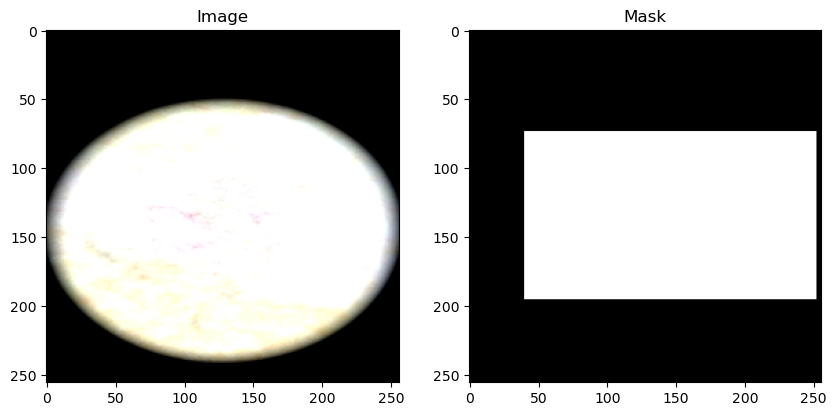

In [9]:
# Check Sample Data

# Create an instance of the DataGenerator
data_gen = DataGenerator(base_dir=base_dir, data_type='train', batch_size=8, augment=True)

# Get a batch of data
images, masks = data_gen.__getitem__(0)

# Plot the first image and mask in the batch
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title("Mask")
plt.show()


In [10]:
# Check Data Shapes and Types
print("Image shape:", images[0].shape)
print("Mask shape:", masks[0].shape)
print("Image dtype:", images[0].dtype)
print("Mask dtype:", masks[0].dtype)


Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Image dtype: float32
Mask dtype: float32


In [11]:
# Check Normalization
print("Image min and max values:", images[0].min(), images[0].max())
print("Mask unique values:", np.unique(masks[0]))


Image min and max values: 0.0 1.0
Mask unique values: [0. 1.]


In [12]:
# Check Batch Consistency
for i in range(len(data_gen)):
    images, masks = data_gen.__getitem__(i)
    assert images.shape == (data_gen.batch_size, data_gen.img_size[0], data_gen.img_size[1], 3), "Incorrect image batch shape"
    assert masks.shape == (data_gen.batch_size, data_gen.img_size[0], data_gen.img_size[1], 1), "Incorrect mask batch shape"
    assert images.dtype == tf.float32, "Incorrect image dtype"
    assert masks.dtype == tf.float32, "Incorrect mask dtype"
    assert images.min() >= 0.0 and images.max() <= 1.0, "Image normalization out of bounds"
    assert set(np.unique(masks)).issubset({0.0, 1.0}), "Masks are not binary"


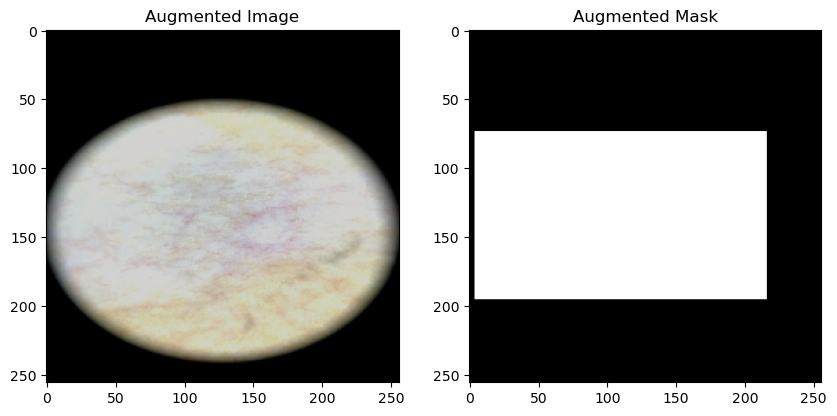

In [13]:
# Check Augmentation
data_gen.augment = True
images_aug, masks_aug = data_gen.__getitem__(0)

# Plot the augmented image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images_aug[0])
plt.title("Augmented Image")
plt.subplot(1, 2, 2)
plt.imshow(masks_aug[0].squeeze(), cmap='gray')
plt.title("Augmented Mask")
plt.show()


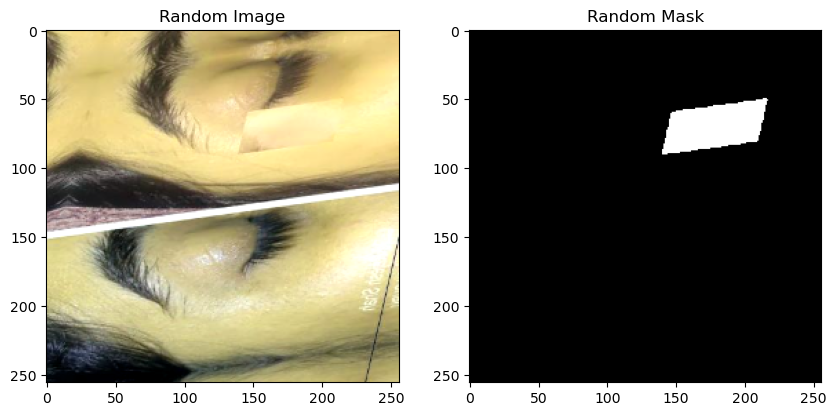

In [14]:
import random

def display_random_batch(data_gen):
    batch_index = random.randint(0, len(data_gen) - 1)
    images, masks = data_gen.__getitem__(batch_index)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0])
    plt.title("Random Image")
    plt.subplot(1, 2, 2)
    plt.imshow(masks[0].squeeze(), cmap='gray')
    plt.title("Random Mask")
    plt.show()

# Display a random batch
display_random_batch(data_gen)


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, SpatialDropout2D, BatchNormalization, Activation, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

def unet_with_resnet50(input_size=(256, 256, 3), pretrained=True):
    inputs = Input(input_size, name='input_layer')

    base_model = ResNet50(include_top=False, weights='imagenet' if pretrained else None, input_tensor=inputs)

    conv1 = base_model.get_layer('conv1_relu').output
    conv2 = base_model.get_layer('conv2_block3_out').output
    conv3 = base_model.get_layer('conv3_block4_out').output
    conv4 = base_model.get_layer('conv4_block6_out').output
    encoder_output = base_model.get_layer('conv5_block3_out').output

    print(f"Shape of encoder output: {encoder_output.shape}")

    up6 = UpSampling2D((2, 2), name='up6')(encoder_output)
    print(f"Shape of up6: {up6.shape}")
    conv4_resized = tf.keras.layers.Resizing(up6.shape[1], up6.shape[2], name='conv4_resized')(conv4)
    print(f"Shape of conv4_resized: {conv4_resized.shape}")
    up6 = concatenate([up6, conv4_resized], axis=-1, name='concat6')
    conv6 = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01), name='conv6')(up6)
    conv6 = SpatialDropout2D(0.3, name='spatial_dropout6')(conv6)
    conv6 = BatchNormalization(name='batch_norm6')(conv6)
    conv6 = Activation('relu', name='activation6')(conv6)

    up7 = UpSampling2D((2, 2), name='up7')(conv6)
    print(f"Shape of up7: {up7.shape}")
    conv3_resized = tf.keras.layers.Resizing(up7.shape[1], up7.shape[2], name='conv3_resized')(conv3)
    print(f"Shape of conv3_resized: {conv3_resized.shape}")
    up7 = concatenate([up7, conv3_resized], axis=-1, name='concat7')
    conv7 = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), name='conv7')(up7)
    conv7 = SpatialDropout2D(0.3, name='spatial_dropout7')(conv7)
    conv7 = BatchNormalization(name='batch_norm7')(conv7)
    conv7 = Activation('relu', name='activation7')(conv7)

    up8 = UpSampling2D((2, 2), name='up8')(conv7)
    print(f"Shape of up8: {up8.shape}")
    conv2_resized = tf.keras.layers.Resizing(up8.shape[1], up8.shape[2], name='conv2_resized')(conv2)
    print(f"Shape of conv2_resized: {conv2_resized.shape}")
    up8 = concatenate([up8, conv2_resized], axis=-1, name='concat8')
    conv8 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), name='conv8')(up8)
    conv8 = SpatialDropout2D(0.3, name='spatial_dropout8')(conv8)
    conv8 = BatchNormalization(name='batch_norm8')(conv8)
    conv8 = Activation('relu', name='activation8')(conv8)

    up9 = UpSampling2D((2, 2), name='up9')(conv8)
    print(f"Shape of up9: {up9.shape}")
    conv1_resized = tf.keras.layers.Resizing(up9.shape[1], up9.shape[2], name='conv1_resized')(conv1)
    print(f"Shape of conv1_resized: {conv1_resized.shape}")
    up9 = concatenate([up9, conv1_resized], axis=-1, name='concat9')
    conv9 = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.01), name='conv9')(up9)
    conv9 = SpatialDropout2D(0.3, name='spatial_dropout9')(conv9)
    conv9 = BatchNormalization(name='batch_norm9')(conv9)
    conv9 = Activation('relu', name='activation9')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', name='output_layer')(conv9)
    outputs = tf.keras.layers.Resizing(256, 256, name='resize_output')(conv10)
    print(f"Shape of outputs: {outputs.shape}")

    model = Model(inputs=[inputs], outputs=[outputs])

    for i in range(len(model.weights)):
        model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

    return model

model = unet_with_resnet50()


Shape of encoder output: (None, 8, 8, 2048)
Shape of up6: (None, 16, 16, 2048)
Shape of conv4_resized: (None, 16, 16, 1024)
Shape of up7: (None, 32, 32, 256)
Shape of conv3_resized: (None, 32, 32, 512)
Shape of up8: (None, 64, 64, 128)
Shape of conv2_resized: (None, 64, 64, 256)
Shape of up9: (None, 128, 128, 64)
Shape of conv1_resized: (None, 128, 128, 64)
Shape of outputs: (None, 256, 256, 1)


In [16]:
# Define loss functions and necessary callbacks
def combined_tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, gamma=1.0):
    y_true = tf.ensure_shape(y_true, [None, 256, 256, 1])
    y_pred = tf.ensure_shape(y_pred, [None, 256, 256, 1])
    
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape}, y_pred shape {y_pred.shape}")
    
    true_pos = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])
    
    tversky_index = (true_pos + 1) / (true_pos + alpha * false_neg + beta * false_pos + 1)
    loss = tf.reduce_mean((1 - tversky_index) ** gamma)
    
    return loss

def combined_tversky_loss_with_weights(weights):
    def loss(y_true, y_pred):
        return combined_tversky_loss(y_true, y_pred, weights[0], weights[1])
    return loss

def compute_class_weights(y_true):
    y_true_flat = tf.reshape(y_true, [-1])
    total_pixels = tf.size(y_true_flat, out_type=tf.float32)
    pos_pixels = tf.reduce_sum(tf.cast(y_true_flat, tf.float32))
    neg_pixels = total_pixels - pos_pixels
    weight_for_0 = neg_pixels / total_pixels
    weight_for_1 = pos_pixels / total_pixels
    class_weights = [weight_for_0.numpy(), weight_for_1.numpy()]
    return class_weights

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

class HistoryCallback(Callback):
    def __init__(self, history_save_path, log_dir):
        super().__init__()
        self.history_save_path = history_save_path
        self.log_dir = log_dir

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs = {k: float(v) if isinstance(v, (int, float)) else str(v) for k, v in logs.items()}
        with open(self.history_save_path, 'a') as f:
            json.dump({epoch: logs}, f)
            f.write("\n")
        # Debug print to check if logging is working
        print(f"Epoch {epoch} logs: {logs}")


In [17]:
# Set random seed and define paths
base_dir = 'E:\\study\\graduation\\vitiligo-assessment\\data'
save_dir = 'E:\\study\\graduation\\vitiligo-assessment\\models\\unet_with_resnet50'
log_dir = 'E:\\study\\graduation\\vitiligo-assessment\\logs\\unet_with_resnet50'
history_save_path = os.path.join(save_dir, 'training_histories.json')

def set_random_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

In [18]:
class WarmupExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps, decay_steps, decay_rate):
        super(WarmupExponentialDecay, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def __call__(self, step):
        initial_learning_rate = tf.convert_to_tensor(self.initial_learning_rate, name="initial_learning_rate")
        dtype = initial_learning_rate.dtype

        warmup_steps_const = tf.constant(self.warmup_steps, dtype=dtype)
        step = tf.cast(step, dtype)

        warmup_lr = self.initial_learning_rate * (step / warmup_steps_const)
        decay_lr = self.initial_learning_rate * tf.math.pow(
            self.decay_rate, 
            (step - warmup_steps_const) / tf.cast(self.decay_steps, dtype)
        )

        learning_rate = tf.cond(step < warmup_steps_const, lambda: warmup_lr, lambda: decay_lr)

        return learning_rate


In [19]:
# Learning rate schedule with warm-up and exponential decay
initial_learning_rate = 1e-4
warmup_steps = 2000
decay_steps = 15000
decay_rate = 0.9

learning_rate_schedule = WarmupExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    warmup_steps=warmup_steps, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate
)



In [20]:
os.makedirs(save_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

history_callback = HistoryCallback(history_save_path, log_dir)

In [21]:
def create_optimizer():
    # Create the optimizer
    base_optimizer = Adam(learning_rate=learning_rate_schedule)

    # Check if mixed precision is enabled
    if tf.config.experimental.list_physical_devices('GPU'):
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)

        # Check if the optimizer is already wrapped
        if not isinstance(base_optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
            optimizer = tf.keras.mixed_precision.LossScaleOptimizer(base_optimizer)
        else:
            optimizer = base_optimizer
    else:
        optimizer = base_optimizer
    
    return optimizer


In [22]:
# Function to get the optimizer name
def get_optimizer_name(optimizer):
    if isinstance(optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
        return optimizer._optimizer.__class__.__name__
    else:
        return optimizer.__class__.__name__

In [23]:
# Preliminary check to ensure the optimizer is not wrapped multiple times
def test_optimizer_compilation():
    try:
        # Create a dummy model for compilation test
        input_tensor = tf.keras.Input(shape=(256, 256, 3))
        dummy_output = tf.keras.layers.Conv2D(1, (3, 3), padding='same')(input_tensor)
        dummy_model = tf.keras.Model(inputs=input_tensor, outputs=dummy_output)

        # Compile the dummy model
        optimizer = create_optimizer()  # Use the optimizer creation function
        dummy_model.compile(optimizer=optimizer,
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

        print("Optimizer and model compilation check passed.")
    except ValueError as e:
        print(f"Error during optimizer compilation check: {e}")

# Run the preliminary compilation check
test_optimizer_compilation()

Optimizer and model compilation check passed.


In [104]:
# Proceed with the rest of your training code
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

batch_size = 16
results[batch_size] = {}

best_weights = None

for fold_index, (train_index, val_index) in enumerate(kf.split(np.arange(len(os.listdir(os.path.join(base_dir, 'train', 'images')))))):
    # Data generators
    train_generator = DataGenerator(base_dir, data_type='train', batch_size=batch_size, img_size=(256, 256), shuffle=True, augment=True)
    val_generator = DataGenerator(base_dir, data_type='valid', batch_size=batch_size, img_size=(256, 256), shuffle=False, augment=False)

    # Model initialization
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(256, 256, 3)))
    base_model.trainable = False

    model = unet_with_resnet50()
    if best_weights:
        model.load_weights(best_weights)

    # Compute class weights
    y_true = np.array(train_generator.collect_all_masks())
    y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
    class_weights = compute_class_weights(y_true_tensor)

    # Re-create the optimizer for each fold to ensure it is fresh
    optimizer = create_optimizer()
    opt_name = get_optimizer_name(optimizer)
    results[batch_size][opt_name] = []

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=combined_tversky_loss_with_weights(class_weights),
                  metrics=['accuracy', iou_metric, dice_coefficient])

    # Setup callbacks
    unique_id = datetime.now().strftime("%Y%m%d%H%M%S") + "_" + uuid.uuid4().hex
    checkpoint_path = os.path.join(save_dir, f'unet_resnet50_bs{batch_size}_opt{opt_name}_fold{fold_index}_{unique_id}')
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, save_freq='epoch', mode='auto', save_weights_only=True, save_format='tf')

    # Train the model
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=150,
                        callbacks=[checkpoint, early_stopping, history_callback])

    # Store training history
    history_serializable = {k: [float(v) for v in values] for k, values in history.history.items()}
    results[batch_size][opt_name].append(history_serializable)

    best_weights = checkpoint_path

    # Fine-tuning
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Recompile the model for fine-tuning
    fine_tune_optimizer = Adam(learning_rate=1e-5)
    model.compile(optimizer=fine_tune_optimizer,
                  loss=combined_tversky_loss_with_weights(class_weights),
                  metrics=['accuracy', iou_metric, dice_coefficient])

    fine_tune_checkpoint_path = os.path.join(save_dir, f'unet_resnet50_finetune_bs{batch_size}_opt{opt_name}_fold{fold_index}_{unique_id}')
    fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    fine_tune_checkpoint = ModelCheckpoint(fine_tune_checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, save_freq='epoch', mode='auto', save_weights_only=True, save_format='tf')

    fine_tune_history = model.fit(train_generator,
                                  validation_data=val_generator,
                                  epochs=30,
                                  callbacks=[fine_tune_checkpoint, fine_tune_early_stopping, history_callback])

    best_weights = fine_tune_checkpoint_path

    # Save the complete model
    model_save_path = os.path.join(save_dir, f'unet_with_resnet50_complete_model_bs{batch_size}_opt{opt_name}_fold{fold_index}_{unique_id}.h5')
    if os.path.exists(model_save_path):
        os.remove(model_save_path)

    # Recompile and save the final model
    temp_optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=temp_optimizer,
                  loss=combined_tversky_loss_with_weights(class_weights),
                  metrics=['accuracy', iou_metric, dice_coefficient])

    model.save(model_save_path)
    print(f"Finished fold {fold_index + 1} of {kf.n_splits}.")

print("K-Fold cross-validation process completed.")

Shape of encoder output: (None, 8, 8, 2048)
Shape of up6: (None, 16, 16, 2048)
Shape of conv4_resized: (None, 16, 16, 1024)
Shape of up7: (None, 32, 32, 256)
Shape of conv3_resized: (None, 32, 32, 512)
Shape of up8: (None, 64, 64, 128)
Shape of conv2_resized: (None, 64, 64, 256)
Shape of up9: (None, 128, 128, 64)
Shape of conv1_resized: (None, 128, 128, 64)
Shape of outputs: (None, 256, 256, 1)
Epoch 1/150
129/129 [==============================] - ETA: 0s - loss: 8.9620 - accuracy: 0.5754 - iou_metric: 0.2489 - dice_coefficient: 0.3912
Epoch 1: val_loss improved from inf to 8.59606, saving model to E:\study\graduation\vitiligo-assessment\models\unet_with_resnet50\unet_resnet50_bs16_optAdam_fold0_20240531025103_fff7cb37231f4c7b86efc0bb4d100f08
Epoch 0 logs: {'loss': 8.96203899383545, 'accuracy': 0.5753880143165588, 'iou_metric': 0.24889926612377167, 'dice_coefficient': 0.39121225476264954, 'val_loss': 8.596059799194336, 'val_accuracy': 0.5463964939117432, 'val_iou_metric': 0.0319027975

In [24]:
test_generator = DataGenerator(base_dir, data_type='test', batch_size=16, img_size=(256, 256), shuffle=False, augment=False)


In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Define the custom loss and metric functions
def combined_tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, gamma=1.0):
    y_true = tf.ensure_shape(y_true, [None, 256, 256, 1])
    y_pred = tf.ensure_shape(y_pred, [None, 256, 256, 1])
    
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape}, y_pred shape {y_pred.shape}")
    
    true_pos = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])
    
    tversky_index = (true_pos + 1) / (true_pos + alpha * false_neg + beta * false_pos + 1)
    loss = tf.reduce_mean((1 - tversky_index) ** gamma)
    
    return loss

def combined_tversky_loss_with_weights(weights):
    def loss(y_true, y_pred):
        return combined_tversky_loss(y_true, y_pred, weights[0], weights[1])
    return loss

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

# Define the class weights
class_weights = [0.5, 0.5]

# Create a specific instance of the loss function with the given weights
loss_instance = combined_tversky_loss_with_weights(class_weights)


In [26]:
# Load the model
model_path = 'E:\\study\\graduation\\results\\REsnet 50\\test 1\\unet_with_resnet50_complete_model_bs16_optAdam_fold0_20240531025103_fff7cb37231f4c7b86efc0bb4d100f08.h5'
model = load_model(model_path, custom_objects={
    'combined_tversky_loss': combined_tversky_loss,
    'loss': loss_instance,  # This ensures the correct instance is passed
    'iou_metric': iou_metric,
    'dice_coefficient': dice_coefficient
})

# Compile the model with the same loss and metrics
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=loss_instance,
              metrics=['accuracy', iou_metric, dice_coefficient])


In [27]:
# Prepare the test data
test_dir = 'E:\\study\\graduation\\vitiligo-assessment\\data\\test'
test_images = [os.path.join(test_dir, 'images', f) for f in os.listdir(os.path.join(test_dir, 'images'))]
test_masks = [os.path.join(test_dir, 'masks', f) for f in os.listdir(os.path.join(test_dir, 'masks'))]

def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0
    return img

def load_mask(file_path):
    mask = tf.io.read_file(file_path)
    mask = tf.image.decode_image(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = mask / 255.0
    return mask

test_images = np.array([load_image(img) for img in test_images])
test_masks = np.array([load_mask(mask) for mask in test_masks])


In [28]:
# Evaluate the model on the test data
results = model.evaluate(test_images, test_masks, batch_size=8)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test IoU Metric: {results[2]}")
print(f"Test Dice Coefficient: {results[3]}")


31/31 [==============================] - 3s 24ms/step - loss: 0.2727 - accuracy: 0.7961 - iou_metric: 0.6351 - dice_coefficient: 0.7517
Test Loss: 0.27267593145370483
Test Accuracy: 0.7960901856422424
Test IoU Metric: 0.6350971460342407
Test Dice Coefficient: 0.7516834735870361


8/8 [==============================] - 2s 80ms/step


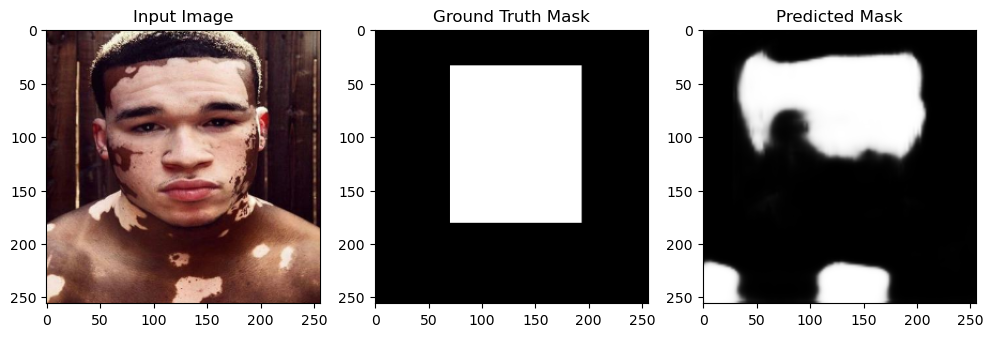

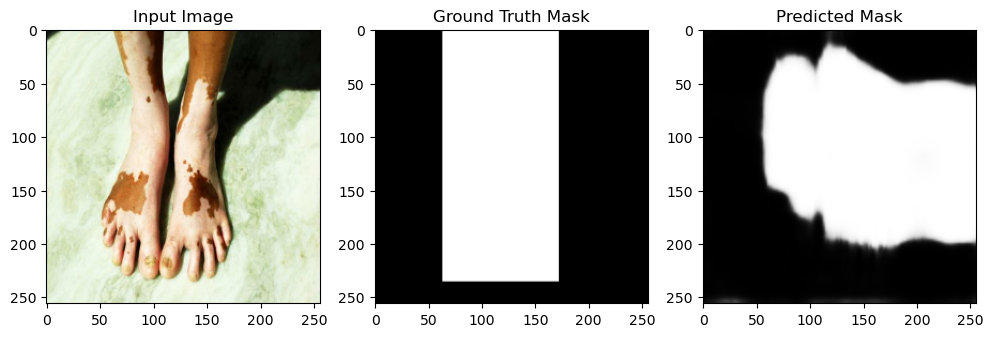

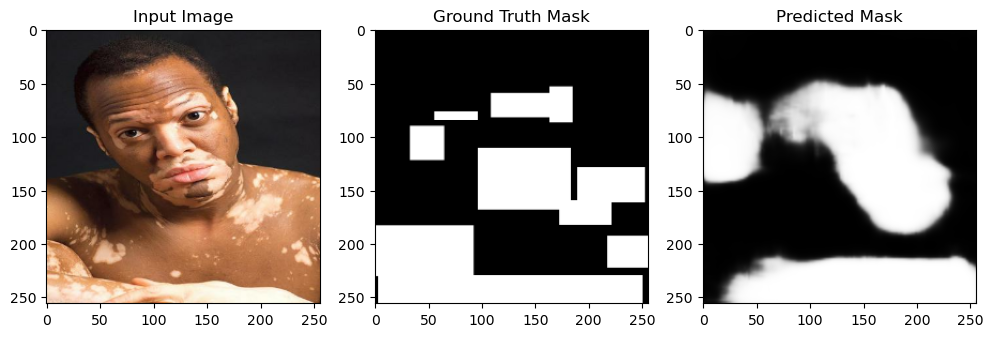

In [30]:
# Predict the masks for the test images
predicted_masks = model.predict(test_images)

# Visualize some sample results
for i in range(3):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title('Input Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[i, :, :, 0], cmap='gray')
    plt.title('Ground Truth Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i, :, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    
    plt.show()


1/1 [==============================] - 0s 385ms/step


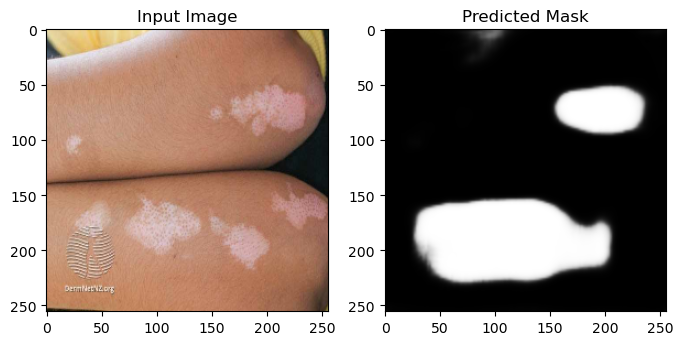

In [31]:
# Load and preprocess a new image for prediction
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Corrected file path with raw string notation
new_image_path = r"E:\study\graduation\Dataset\DermNet\vitiligo-0010__WatermarkedWyJXYXRlcm1hcmtlZCJd.jpg"
new_image = load_and_preprocess_image(new_image_path)

# Predict mask for the new image
predicted_mask = model.predict(new_image)[0]

# Visualize the input image and the predicted mask
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(new_image[0])
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()


8/8 [==============================] - 0s 49ms/step


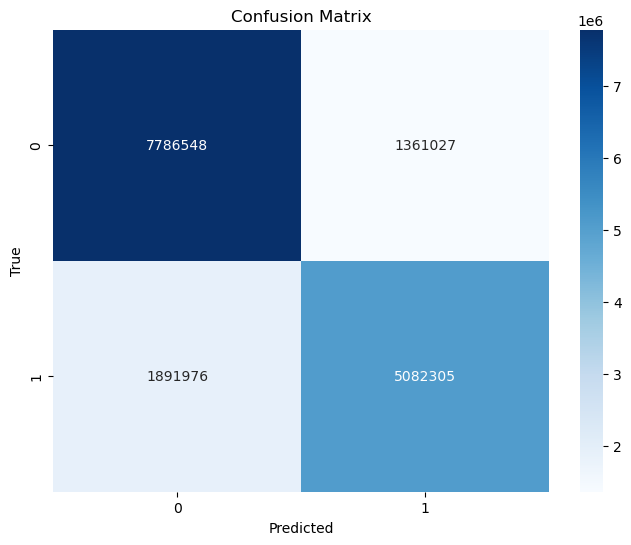

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your model and test data loaded
# model: your trained model
# test_images: your test images
# test_masks: your ground truth masks for the test images

# Predict on the test images
y_pred = model.predict(test_images)
y_pred = (y_pred > 0.5).astype(np.uint8)  # Convert probabilities to binary masks

# Flatten the arrays for confusion matrix computation
y_true_flat = test_masks.flatten()
y_pred_flat = y_pred.flatten()

# Ensure y_true is binary
y_true_flat = (y_true_flat > 0.5).astype(np.uint8)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


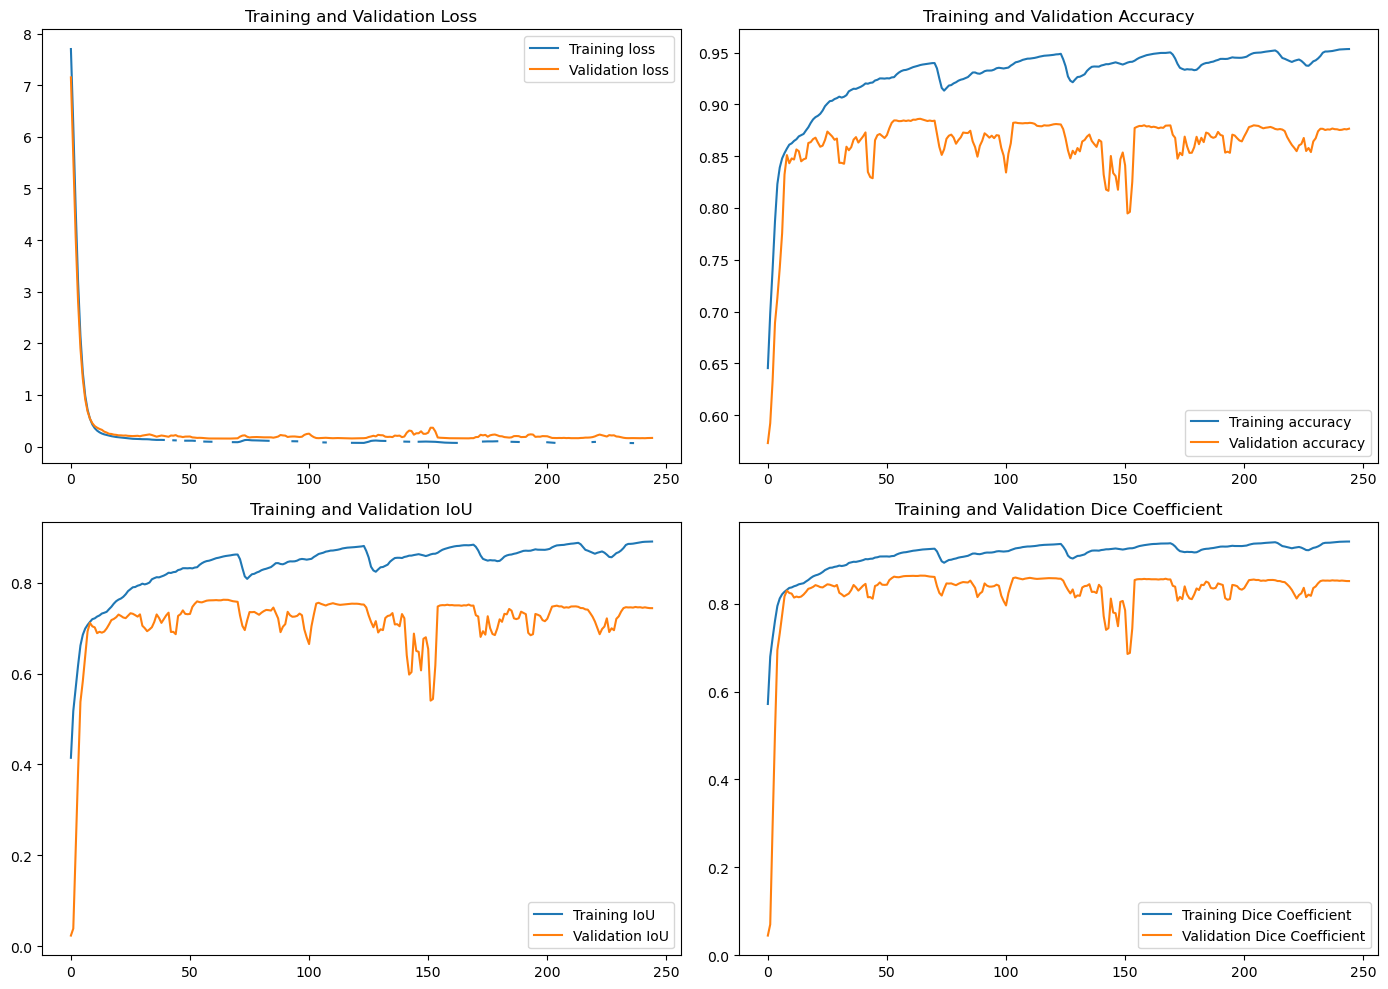

In [33]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load JSON lines from the file
file_path = "E:/study/graduation/results/REsnet 50/test 1/training_histories.json"
history = []
with open(file_path, 'r') as f:
    for line in f:
        history.append(json.loads(line.strip()))

# Aggregate the data
history_dict = {
    'loss': [h[list(h.keys())[0]]['loss'] for h in history],
    'val_loss': [h[list(h.keys())[0]]['val_loss'] for h in history],
    'accuracy': [h[list(h.keys())[0]]['accuracy'] for h in history],
    'val_accuracy': [h[list(h.keys())[0]]['val_accuracy'] for h in history],
    'iou_metric': [h[list(h.keys())[0]]['iou_metric'] for h in history],
    'val_iou_metric': [h[list(h.keys())[0]]['val_iou_metric'] for h in history],
    'dice_coefficient': [h[list(h.keys())[0]]['dice_coefficient'] for h in history],
    'val_dice_coefficient': [h[list(h.keys())[0]]['val_dice_coefficient'] for h in history]
}

# Function to compute moving average
def moving_average(data, window_size):
    if window_size > len(data):
        window_size = len(data)
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 3

# Apply moving average to smooth the data
smoothed_history_dict = {
    'loss': moving_average(history_dict['loss'], window_size),
    'val_loss': moving_average(history_dict['val_loss'], window_size),
    'accuracy': moving_average(history_dict['accuracy'], window_size),
    'val_accuracy': moving_average(history_dict['val_accuracy'], window_size),
    'iou_metric': moving_average(history_dict['iou_metric'], window_size),
    'val_iou_metric': moving_average(history_dict['val_iou_metric'], window_size),
    'dice_coefficient': moving_average(history_dict['dice_coefficient'], window_size),
    'val_dice_coefficient': moving_average(history_dict['val_dice_coefficient'], window_size)
}

# Plot training and validation metrics
epochs = range(len(smoothed_history_dict['iou_metric']))

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, smoothed_history_dict['loss'], label='Training loss')
plt.plot(epochs, smoothed_history_dict['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, smoothed_history_dict['accuracy'], label='Training accuracy')
plt.plot(epochs, smoothed_history_dict['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, smoothed_history_dict['iou_metric'], label='Training IoU')
plt.plot(epochs, smoothed_history_dict['val_iou_metric'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, smoothed_history_dict['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(epochs, smoothed_history_dict['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()
